This kernel trains a Variational Autoencoder in Keras with Gaussian input and output.

Import Keras and other necessary libraries:

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing, metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, Lambda, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

Read data and set train/validation/test split:

In [2]:
#read the dataset
csv = pd.read_csv("creditcard.csv")

test_split = 0.3 #portion of data used for testing
val_split = 0.2 #portion of training data used for validation

Prepare training, validation and test datasets:

In [3]:
data = csv.astype('float32').copy()
data.sort_values('Time', inplace=True)

first_test = int(data.shape[0] * (1 - test_split))
first_val = int(first_test * (1 - val_split))

train = data.iloc[:first_val]
val = data.iloc[first_val:first_test]
test = data.iloc[first_test:]

x_train_df, x_val_df, x_test_df = train.iloc[:, 1:-2], val.iloc[:, 1:-2], test.iloc[:, 1:-2]
y_train_df, y_val_df, y_test_df = train.iloc[:, -1], val.iloc[:, -1], test.iloc[:, -1]

x_train, x_val, x_test = x_train_df.values, x_val_df.values, x_test_df.values
y_train, y_val, y_test = y_train_df.values, y_val_df.values, y_test_df.values

scaler = preprocessing.StandardScaler()

x_train, x_val, x_test = scaler.fit_transform(x_train), scaler.fit_transform(x_val), scaler.fit_transform(x_test)


Build the model and print summary:

In [6]:
import tensorflow._api.v2.compat.v1 as tf

tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [7]:
hidden_size = 16 #size of the hidden layer in encoder and decoder
latent_dim = 2 #number of latent variables to learn

input_dim = x_train.shape[1]

x = Input(shape=(input_dim,))
t = BatchNormalization()(x)
t = Dense(hidden_size, activation='tanh' , name='encoder_hidden')(t)
t = BatchNormalization()(t)

z_mean = Dense(latent_dim, name='z_mean')(t)
z_log_var = Dense(latent_dim, name='z_log_var')(t)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, name='z_sampled')([z_mean, z_log_var])
#t = BatchNormalization()(z)

t = Dense(hidden_size, activation='tanh', name='decoder_hidden')(z)
#t = BatchNormalization()(t)

decoded_mean = Dense(input_dim, activation=None, name='decoded_mean')(t)

vae = Model(x, decoded_mean)

def rec_loss(y_true, y_pred):
    return K.sum(K.square(y_true - y_pred), axis=-1)

def kl_loss(y_true, y_pred):
    return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

def vae_loss(x, decoded_mean):
    rec_loss = K.sum(K.square(x - decoded_mean), axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean((rec_loss + kl_loss) / 2)

vae.compile(optimizer=Adam(lr=1e-2), loss=vae_loss, metrics=[rec_loss, kl_loss])
vae.summary()


Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28)]         0           []                               
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 28)          112         ['input_1[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 encoder_hidden (Dense)         (None, 16)           464         ['batch_normalization_2[0][0]']  
                                                                                                  
 batch_normalization

Train the model with early stopping and a kind of learning rate schedule for the specified number of epochs with the specified batch size:

In [8]:
n_epochs = 30
batch_size = 128

early_stopping = EarlyStopping(monitor='loss', patience=10, min_delta=1e-5) #stop training if loss does not decrease with at least 0.00001
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, min_delta=1e-5, factor=0.2) #reduce learning rate (divide it by 5 = multiply it by 0.2) if loss does not decrease with at least 0.00001

callbacks = [early_stopping, reduce_lr]

#collect training data in history object
history = vae.fit(x_train, x_train, 
                  validation_data=(x_val, x_val), 
                  batch_size=batch_size, epochs=n_epochs, 
                  callbacks=callbacks)


Train on 159491 samples, validate on 39873 samples
Epoch 1/30
156288/159491 [============================>.] - ETA: 0s - loss: 13.2233 - rec_loss: 25.0466 - kl_loss: 1.4000

D:\anaconda3\lib\site-packages\keras\engine\training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


159491/159491 [==============================] - 2s 12us/sample - loss: 13.2271 - rec_loss: 25.0456 - kl_loss: 1.4086 - val_loss: 14.1580 - val_rec_loss: 26.9192 - val_kl_loss: 1.3967 - lr: 0.0100
Epoch 2/30
159491/159491 [==============================] - 1s 9us/sample - loss: 12.3254 - rec_loss: 22.7123 - kl_loss: 1.9385 - val_loss: 14.1475 - val_rec_loss: 26.7984 - val_kl_loss: 1.4966 - lr: 0.0100
Epoch 3/30
159491/159491 [==============================] - 1s 9us/sample - loss: 12.0502 - rec_loss: 22.0851 - kl_loss: 2.0153 - val_loss: 14.0941 - val_rec_loss: 26.5883 - val_kl_loss: 1.5998 - lr: 0.0100
Epoch 4/30
159491/159491 [==============================] - 2s 9us/sample - loss: 12.0012 - rec_loss: 21.9627 - kl_loss: 2.0397 - val_loss: 14.0912 - val_rec_loss: 26.5496 - val_kl_loss: 1.6328 - lr: 0.0100
Epoch 5/30
159491/159491 [==============================] - 2s 10us/sample - loss: 11.8992 - rec_loss: 21.7101 - kl_loss: 2.0883 - val_loss: 14.1380 - val_rec_loss: 26.6938 - val_kl_

Plotting training and validation loss:

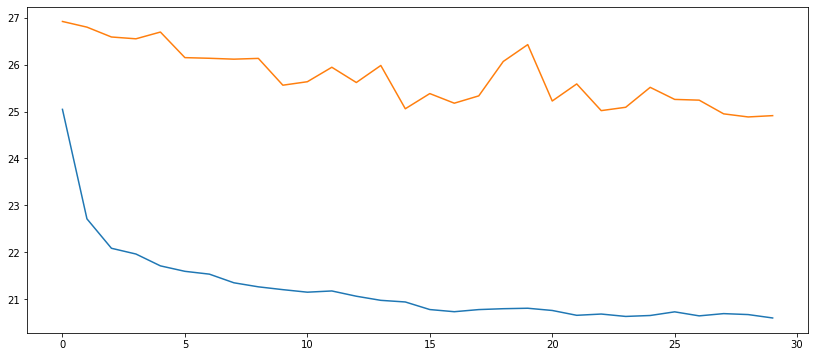

In [9]:
fig = plt.figure(figsize=(14, 6))
ax = fig.gca()
ax.plot(history.history['rec_loss']);
ax.plot(history.history['val_rec_loss']);


Plotting the learned latent representations for normal and anomalous instances in the specified dataset (training/validation/test):

D:\anaconda3\lib\site-packages\keras\engine\training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


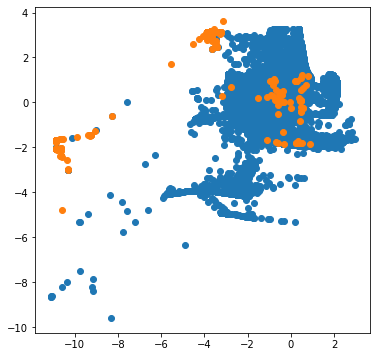

In [10]:
x_data = x_train
y_data = y_train

encoder = Model(x, z_mean)

with_labels = np.concatenate([x_data, np.reshape(y_data, (-1, 1))], axis=1) #concatenate x and y to be able to filter by class

normal = with_labels[np.where(with_labels[:, -1] == 0)] #filter normal instances
anomalous = with_labels[np.where(with_labels[:, -1] == 1)] #filter anomalous instances

normal_encoded = encoder.predict(normal[:, :-1], batch_size=128)
anomalous_encoded = encoder.predict(anomalous[:, :-1], batch_size=128)

fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

#semicolon at the end hides unnecessary output
ax.scatter(normal_encoded[:, 0], normal_encoded[:, 1]);
ax.scatter(anomalous_encoded[:, 0], anomalous_encoded[:, 1]);


Apply simple Linear Discriminant Analysis to learned features (the latent representations):

In [11]:
with_labels_encoded = encoder.predict(with_labels[:, :-1], batch_size=128)

X = with_labels_encoded
y = with_labels[:, -1]

clf = LinearDiscriminantAnalysis()
clf.fit(X, y)

pred = clf.predict(X)

print("AUC(ROC): " + str(metrics.roc_auc_score(y, pred)))
print("Precision: " + str(metrics.precision_score(y, pred)))
print("Recall: " + str(metrics.recall_score(y, pred)))
print("F1 score: " + str(metrics.f1_score(y, pred)))

tn, fp, fn, tp = metrics.confusion_matrix(y, pred).ravel()

print("False positives: " + str(fp))
print("True positives: " + str(tp))
print("False negatives: " + str(fn))
print("True negateives: " + str(tn))

AUC(ROC): 0.8816768798875098
Precision: 0.3289156626506024
Recall: 0.7668539325842697
F1 score: 0.4603709949409781
False positives: 557
True positives: 273
False negatives: 83
True negateives: 158578
